<a href="https://colab.research.google.com/github/holehouse-lab/EnsPredict-colab/blob/main/example_notebooks/polymer_property_predictors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welcome to IDPEnsemble Predictor

In [2]:
#@title Install Necessary Dependencies
!pip install git+https://git@github.com/idptools/sparrow.git@polymer_predictors --quiet;

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.6/142.6 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 476.7/476.7 kB 28.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.5/101.5 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.0/58.0 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 59.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 54.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 56.5 MB/s eta 0:00:00


In [33]:
#@title File Imports
import sparrow
from sparrow.predictors.batch_predict import batch_predict
from google.colab import data_table
import pandas as pd
from sparrow.sparrow_exceptions import SparrowException
import matplotlib.pyplot as plt
from google.colab import files
import io
import os
from collections import defaultdict
import torch

In [4]:
#@title Target Sequence
#@markdown <h1>Enter the primary amino acid sequence:</h1>

#@markdown Notes: 

#@markdown - The following predictors implicitly assume this sequence is disordered.

#@markdown - A sequence cannot be provided at the same time as a fasta file.

# define the function that will be called when the form is submitted
def process_form():
    uploaded_data = files.upload()
    uploaded_fasta = list(uploaded_data.keys())[0]
    # Load protein objects
    try:
      protein_objs = sparrow.read_fasta(uploaded_fasta)
    except TypeError as e:
      print(f"Received TypeError: Perhaps you didn't upload a file?")
      raise e

    return protein_objs



sequence = "THISISANAMINAACIDSEQWENCE" #@param {type:"string"}
fasta_file = False #@param {type:"boolean"}


if fasta_file and len(sequence) > 0:
  raise SparrowException(f"Cannot specify both a sequence and a list of sequences from a fasta file simultaneously")

if fasta_file:
    protein_objs = process_form()
    for protein in protein_objs:
        if len(protein) > 750:
            raise SparrowException(f"Sequences longer than 750 residues are not currently supported."\
            "You entered a protein with length {len(protein)} residues")
else:
    if len(sequence) > 750:
        raise SparrowException(f"Sequences longer than 750 residues are not currently supported."\
            "You entered a protein with length {len(sequence)} residues")
    
    protein_objs = sparrow.Protein(sequence)
    

In [31]:
#@title Sequence Property Prediction

#@markdown <h1>Please select the ensemble features you'd like to predict and then press the run cell button: </h1>

#@markdown Predictions can be run on CPU or GPU. Bulk predictions form fasta may be slow on CPU.

radius_of_gyration = True #@param {type:"boolean"}
end_to_end_distance = True #@param {type:"boolean"}
scaling_exponent = True #@param {type:"boolean"}
prefactor = True #@param {type:"boolean"}
asphericity = True #@param {type:"boolean"}

def __gpu_accelerated_fasta_predictions(protein_objs):
    
    dfs = []
    labels = {header : protein.sequence for header,protein in protein_objs.items()}
    lengths = {protein.sequence : int(len(protein)) for header, protein in protein_objs.items()}
    
    dfs.append(pd.DataFrame(list(labels.items()), columns=['fasta_header', 'sequence']))
    dfs.append(pd.DataFrame(list(lengths.items()), columns=['sequence', 'lengths']))
    if radius_of_gyration:
        radius_of_gyrations = batch_predict(protein_objs,batch_size=32,network="rg")
        dfs.append(pd.DataFrame(list(radius_of_gyrations.items()), columns=['sequence', 'radius_of_gyration']))

    if end_to_end_distance:
        end_to_end_distances = batch_predict(protein_objs,batch_size=32,network="re")
        dfs.append(pd.DataFrame(list(end_to_end_distances.items()), columns=['sequence', 'end_to_end_distance']))
                
    if scaling_exponent:
        scaling_exponents = batch_predict(protein_objs,batch_size=32,network="scaling_exponent")
        dfs.append(pd.DataFrame(list(scaling_exponents.items()), columns=['sequence', 'scaling_exponent']))

    if asphericity:
        asphericitys = batch_predict(protein_objs,batch_size=32,network="asphericity") 
        dfs.append(pd.DataFrame(list(asphericitys.items()), columns=['sequence', 'asphericity']))
        
    if prefactor:
        prefactors = batch_predict(protein_objs,batch_size=32,network="prefactor") 
        dfs.append(pd.DataFrame(list(prefactors.items()), columns=['sequence', 'prefactor']))

    merged_df = dfs[0]  # initialize merged_df with the first dataframe

    for df in dfs[1:]:  # iterate over the remaining dataframes
        # merge on 'key' column
        merged_df = pd.merge(merged_df, df, on='sequence')  
        # move 'sequence' column to the end
        merged_df = merged_df[[col for col in merged_df.columns if col != 'sequence'] + ['sequence']] 
    
    return merged_df
    
def __cpu_fasta_predictions(protein_objs):
    dimensions = defaultdict(dict)

    for i, (header, protein) in enumerate(protein_objs.items(), 1):
        dimensions[header].update({"length" : int(len(protein))})
        dimensions[header].update({"sequence" : protein.sequence})

        if radius_of_gyration:
            dimensions[header].update({"radius_of_gyration" : protein.predictor.radius_of_gyration()})
        
        if end_to_end_distance:
            dimensions[header].update({"end_to_end_distance" : protein.predictor.end_to_end_distance()})

        if scaling_exponent:
            dimensions[header].update({"scaling_exponent" : protein.predictor.scaling_exponent()})

        if asphericity:
            dimensions[header].update({"asphericity" : protein.predictor.asphericity()})

        if prefactor:
            dimensions[header].update({"prefactor" : protein.predictor.prefactor()})

    df = pd.DataFrame(dimensions).T
    df = df.rename_axis('fasta_header')
    df = df[[col for col in df.columns if col != 'sequence'] + ['sequence']] 

    return df

def return_fasta_predictions(protein_objs):
    if torch.cuda.is_available():
        df = __gpu_accelerated_fasta_predictions(protein_objs)
    else:
        df = __cpu_fasta_predictions(protein_objs)
        
    return df

def return_individual_predictions(protein):
    print("here")
    dimensions = defaultdict(dict)
    col_names = []
    
    dimensions[f"{protein.sequence}"].update({"length" : int(len(protein))})
    col_names.append("length")

    if radius_of_gyration:
        dimensions[f"{protein.sequence}"].update({"radius_of_gyration" : protein.predictor.radius_of_gyration()})
        col_names.append("radius_of_gyration")
    if end_to_end_distance:
        dimensions[f"{protein.sequence}"].update({"end_to_end_distance" : protein.predictor.end_to_end_distance()})
        col_names.append("end_to_end_distance")
    if scaling_exponent:
        dimensions[f"{protein.sequence}"].update({"scaling_exponent" : protein.predictor.scaling_exponent()})
        col_names.append("scaling_exponent")
    if asphericity:
        dimensions[f"{protein.sequence}"].update({"asphericity" : protein.predictor.asphericity()})
        col_names.append("asphericity")

    if prefactor:
        dimensions[f"{protein.sequence}"].update({"prefactor" : protein.predictor.prefactor()})
        col_names.append("prefactor")

    df = pd.DataFrame(dimensions).T
    df = df.rename_axis('sequence')
    df = df.reindex(columns=col_names)


    return df

def is_iterable(obj):
    try:
        iter(obj)
        return True
    except TypeError:
        return False


if is_iterable(protein_objs):
    df = return_fasta_predictions(protein_objs)
else:
    df = return_individual_predictions(protein_objs)


display(data_table.DataTable(df, include_index=True, num_rows_per_page=5))


here


,length,radius_of_gyration,end_to_end_distance,scaling_exponent,asphericity,prefactor
sequence,,,,,,
THISISANAMINAACIDSEQWENCE,25.0,12.45053,31.149883,0.523952,0.456221,5.844594


In [35]:
#@title Download the CSV file containing your predictions

#@markdown <h1>Name of the CSV file that you'd like to save</h1>

filename = "sequence.csv" #@param {type:"string"}

filename = os.path.splitext(filename)[0]

if filename:
    df.to_csv(f"{filename}.csv")

    files.download(f'{filename}.csv')



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

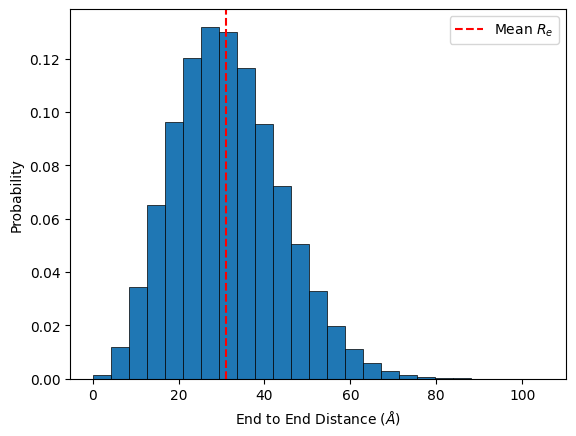

In [7]:
#@title Plot predicted end-to-end-distribution
bins = 25 #@param {type:"integer"}
if is_iterable(protein_objs):
    raise SparrowException("We don't currently support predicting end-to-end distance distributions from fasta files. Please use the single sequence method in the cell above.")

p_of_Re_R, p_of_Re_P = protein_objs.polymeric.get_predicted_nu_dep_end_to_end_distribution()
plt.hist(p_of_Re_R, weights=p_of_Re_P, linewidth=0.5, edgecolor='k',bins=bins)
plt.xlabel(r"End to End Distance ($\AA$)")
plt.ylabel("Probability")
plt.axvline(protein_objs.predictor.end_to_end_distance(), linestyle="--",color='r',label=r"Mean $R_e$")
plt.legend()
plt.show()